In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from model import *
from utils import *
import seaborn as sns
sns.set(style='whitegrid')
device = torch.device("cuda")

In [2]:
def sample_batch_teacher(B, d_in, device="cuda"):
        W1, W2, W3 = teacher_weights
        x = torch.randn(B, d_in, device=device) / math.sqrt(d_in)
        h = torch.tanh(x @ W1) * 1.5927
        h = torch.tanh(h @ W2) * 1.5927
        y = h @ W3
        return x, y

def train_mup(d_in, widths, B, T, lrs, sample_batch_fn, device="cuda"):
    train_losses = {w: {lr:[] for lr in lrs} for w in widths}
    loss_fn = nn.MSELoss()
    for width in widths:
        for lr in lrs:
            model = MLP2Hidden(d_in, width, 1).to(device)
            model.init_weights_mup()
            optimizer = model.init_optimizer_mup(lr)
            model.train()
            for step in range(T):
                x, y_true = sample_batch_fn(B, d_in, device=device)
                optimizer.zero_grad()
                y_pred = model(x)
                loss = loss_fn(y_pred, y_true)
                loss.backward()
                optimizer.step()
                train_losses[width][lr].append(loss.item())
    return train_losses

def train_ntk(d_in, widths, B, T, lrs, sample_batch_fn, device="cuda"):
    train_losses = {w: {lr:[] for lr in lrs} for w in widths}
    loss_fn = nn.MSELoss()
    for width in widths:
        for lr in lrs:
            model = MLP2Hidden(d_in, width, 1).to(device)
            model.init_weights_ntk()
            optimizer = model.init_optimizer_ntk(lr)
            model.train()
            for step in range(T):
                x, y_true = sample_batch_fn(B, d_in, device=device)
                optimizer.zero_grad()
                y_pred = model(x)
                loss = loss_fn(y_pred, y_true)
                loss.backward()
                optimizer.step()
                train_losses[width][lr].append(loss.item())
    return train_losses

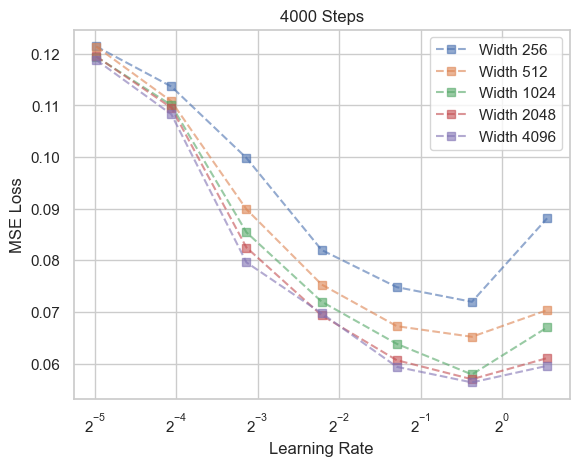

In [3]:
d_in=30
widths = [256, 512, 1024, 2048, 4096]
B = 512
T = 4000
lrs = np.logspace(-1.5, 1.0, 10)

teacher_weights = make_teacher(d_in, device, seed=42, teacher_width = 10000)

train_losses4k = train_mup(d_in, widths, B, T, lrs, sample_batch_teacher, device)
display_results(widths, lrs, train_losses4k, title='4000 Steps')


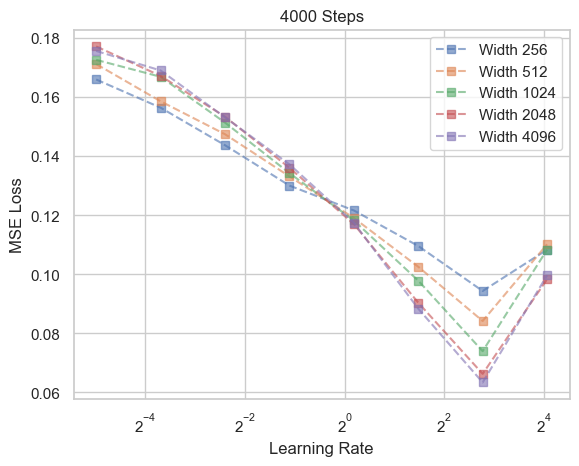

In [10]:
d_in=30
widths = [256, 512, 1024, 2048, 4096]
B = 512
T = 4000
lrs = np.logspace(-1.5, 2.0, 10)

teacher_weights = make_teacher(d_in, device, seed=42, teacher_width = 10000)

train_losses4k_ntk = train_ntk(d_in, widths, B, T, lrs, sample_batch_teacher, device)
display_results(widths, lrs, train_losses4k_ntk, title='4000 Steps')

(0.05, 0.15)

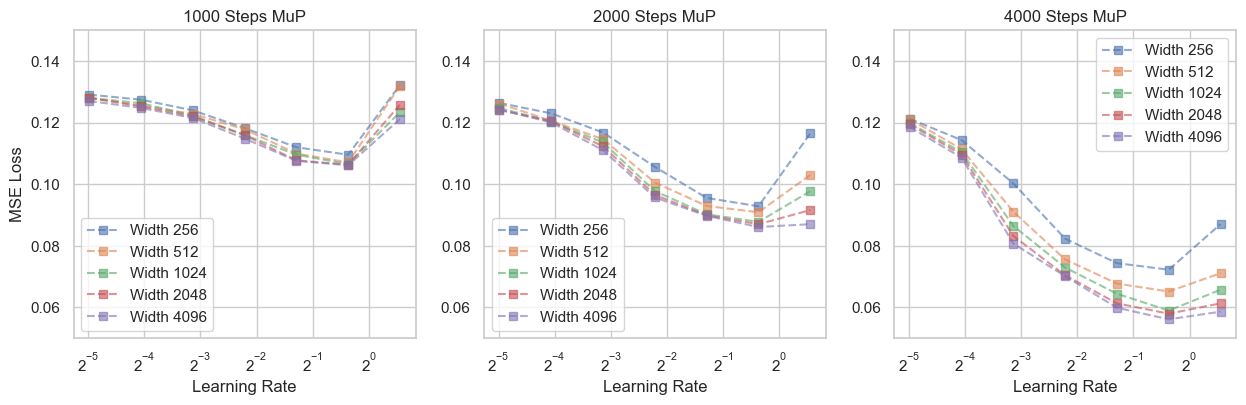

In [17]:
#MuP

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
eta_values = np.logspace(-1.5, 1.0, 10)
ax = axes[0]
for idx, width in enumerate(widths):
        t_losses = [np.mean(train_losses4k[width][lr][1000-300:1000]) for lr in eta_values]
        ax.plot(eta_values, t_losses, marker='s', alpha=0.6, linestyle='--', label=f'Width {width}')
ax.set_title('1000 Steps MuP')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('MSE Loss')
ax.legend()
ax.set_xscale('log', base=2)
ax.set_ylim(0.05, 0.15)
ax = axes[1]
for idx, width in enumerate(widths):
        t_losses = [np.mean(train_losses4k[width][lr][2000-300:2000]) for lr in eta_values]
        ax.plot(eta_values, t_losses, marker='s', alpha=0.6, linestyle='--', label=f'Width {width}')
ax.set_title('2000 Steps MuP')
ax.set_xlabel('Learning Rate')
ax.legend()
ax.set_xscale('log', base=2)
ax.set_ylim(0.05, 0.15)
ax = axes[2]
for idx, width in enumerate(widths):
        t_losses = [np.mean(train_losses4k[width][lr][-300:]) for lr in eta_values]
        ax.plot(eta_values, t_losses, marker='s', alpha=0.6, linestyle='--', label=f'Width {width}')
ax.set_title('4000 Steps MuP')
ax.set_xlabel('Learning Rate')
ax.legend()
ax.set_xscale('log', base=2)
ax.set_ylim(0.05, 0.15)

(0.05, 0.2)

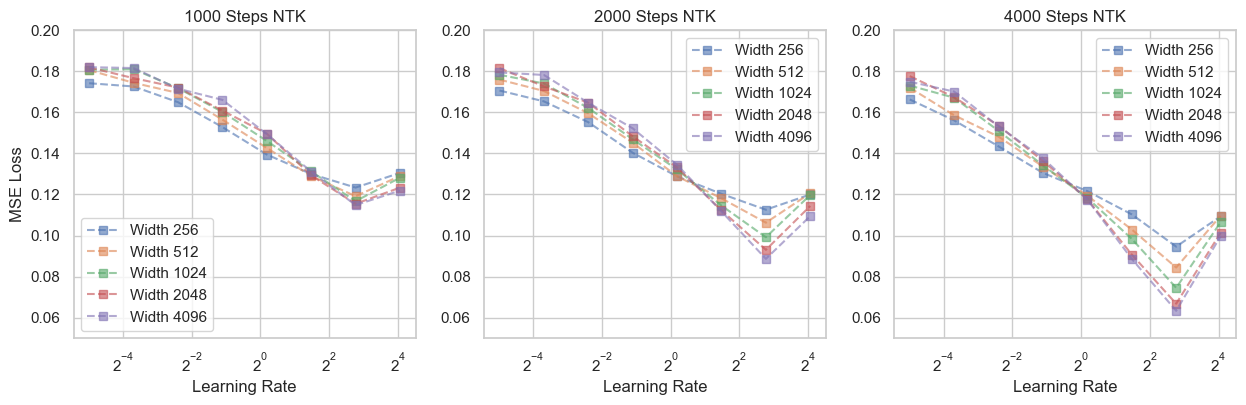

In [16]:
#NTK


fig, axes = plt.subplots(1, 3, figsize=(15, 4))
eta_values = np.logspace(-1.5, 2.0, 10)

ax = axes[0]
for idx, width in enumerate(widths):
        t_losses = [np.mean(train_losses4k_ntk[width][lr][1000-200:1000]) for lr in eta_values]
        ax.plot(eta_values, t_losses, marker='s', alpha=0.6, linestyle='--', label=f'Width {width}')
ax.set_title('1000 Steps NTK')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('MSE Loss')
ax.legend()
ax.set_xscale('log', base=2)
ax.set_ylim(0.05, 0.20)
ax = axes[1]
for idx, width in enumerate(widths):
        t_losses = [np.mean(train_losses4k_ntk[width][lr][2000-200:2000]) for lr in eta_values]
        ax.plot(eta_values, t_losses, marker='s', alpha=0.6, linestyle='--', label=f'Width {width}')
ax.set_title('2000 Steps NTK')
ax.set_xlabel('Learning Rate')
ax.legend()
ax.set_xscale('log', base=2)
ax.set_ylim(0.05, 0.20)
ax = axes[2]
for idx, width in enumerate(widths):
        t_losses = [np.mean(train_losses4k_ntk[width][lr][-300:]) for lr in eta_values]
        ax.plot(eta_values, t_losses, marker='s', alpha=0.6, linestyle='--', label=f'Width {width}')
ax.set_title('4000 Steps NTK')
ax.set_xlabel('Learning Rate')
ax.legend()
ax.set_xscale('log', base=2)
ax.set_ylim(0.05, 0.20)